<a href="https://colab.research.google.com/github/Juan-Hidalgo04/DataScience/blob/main/Proyecto_PArteIII_Hidalgo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Projecto Final Data Science: Predicción de volumen de llamadas

##Objetivo:
Predecir un modelo de Machine learning para predecir si una llamada contestada recibirá un Survey basado en un historico de llamadas. Utilizaré RandomForestClassifier

El objetivo es predecir si una llamada recibirá survey (1) o no recibirá Survey (0)

##Dataset
### [Enlace de la base de datos en Sheets](https://docs.google.com/spreadsheets/d/1iDrFHG0DZwh2T8yJ17cdz_0vTX3ot8sLYX-O9o8mxmU/edit?usp=sharing)

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [65]:
# Configuraciones para visualización
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [66]:
from google.colab import auth
import gspread
from google.auth import default
from gspread_dataframe import get_as_dataframe

In [67]:
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

In [68]:
sheet_url = 'https://docs.google.com/spreadsheets/d/1iDrFHG0DZwh2T8yJ17cdz_0vTX3ot8sLYX-O9o8mxmU/'
sheet = gc.open_by_url(sheet_url).sheet1
df = get_as_dataframe(sheet)

In [69]:
df.head()

/usr/local/lib/python3.11/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")


,Call ID,Call Start Time,Call Accepted,Call End Time,Call Type,Owner Name,Team Lead,Client,Queue Name,Primary Call Reason,Call Resolution,Disconnect Reason,Call Duration in Minutes,Wait Time,Survey,Abandoned Call,Date,Month,Week,Day
0,478203,"8/1/2024, 5:10 AM",NaN,"8/1/2024, 5:12 AM",Inbound,NaN,NaN,Client 5,English,NaN,NaN,CUSTOMER_DISCONNECT,NaN,1.73,NaN,1,8/1/2024,August,7/29/2024,Thursday
1,486465,"8/5/2024, 1:12 PM","8/5/2024, 1:12 PM","8/5/2024, 1:14 PM",Inbound,santiago zapata,Pablo,Client 4,English,General practice questions,Resolved,CUSTOMER_DISCONNECT,1.93,0.15,NaN,0,8/5/2024,August,8/5/2024,Monday
2,494545,"8/8/2024, 8:58 AM","8/8/2024, 9:01 AM","8/8/2024, 9:05 AM",Inbound,samuel bedoya,Samuel,Client 8,English,Billing - Statement Clarification/Explanation,Resolved,CUSTOMER_DISCONNECT,4.25,2.63,NaN,0,8/8/2024,August,8/5/2024,Thursday
3,502769,"8/12/2024, 10:33 AM","8/12/2024, 1:50 PM","8/12/2024, 1:56 PM",Callback,harlen rosario,Stiven,Client 11,English,Clinical - Prescription,Resolved,CUSTOMER_DISCONNECT,5.53,NaN,NaN,0,8/12/2024,August,8/12/2024,Monday
4,478204,"8/1/2024, 5:16 AM",NaN,"8/1/2024, 5:17 AM",Inbound,NaN,NaN,Client 5,English,NaN,NaN,CUSTOMER_DISCONNECT,NaN,0.65,NaN,1,8/1/2024,August,7/29/2024,Thursday


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59201 entries, 0 to 59200
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Call ID                   59201 non-null  int64  
 1   Call Start Time           59201 non-null  object 
 2   Call Accepted             54143 non-null  object 
 3   Call End Time             59201 non-null  object 
 4   Call Type                 59201 non-null  object 
 5   Owner Name                54129 non-null  object 
 6   Team Lead                 48578 non-null  object 
 7   Client                    59184 non-null  object 
 8   Queue Name                59201 non-null  object 
 9   Primary Call Reason       52478 non-null  object 
 10  Call Resolution           52761 non-null  object 
 11  Disconnect Reason         59195 non-null  object 
 12  Call Duration in Minutes  54143 non-null  float64
 13  Wait Time                 51007 non-null  float64
 14  Survey

In [71]:
df.describe()

,Call ID,Call Duration in Minutes,Wait Time,Survey,Abandoned Call
count,59201.000000,54143.000000,51007.000000,3926.000000,59201.000000
mean,513402.294235,4.867178,1.531622,4.804636,0.085438
std,20356.392016,4.698227,3.426496,0.733399,0.279534
min,478203.000000,0.000000,0.020000,1.000000,0.000000
25%,495676.000000,1.800000,0.180000,5.000000,0.000000
50%,513364.000000,3.600000,0.330000,5.000000,0.000000
75%,531036.000000,6.500000,1.820000,5.000000,0.000000
max,548472.000000,176.170000,479.720000,5.000000,1.000000


In [72]:
df['Abandoned Call'].unique()

array([1, 0])

In [73]:
df['Survey'].unique()

array([nan,  5.,  4.,  1.,  3.,  2.])

Acotación:
Como para el proyecto, solo vamos a considerar las llamadas contestadas, creamos una nueva base de datos con solo las llamadas contestadas.

In [74]:
df1 = df[df['Abandoned Call'] == 0]

In [75]:
df1.head()

,Call ID,Call Start Time,Call Accepted,Call End Time,Call Type,Owner Name,Team Lead,Client,Queue Name,Primary Call Reason,Call Resolution,Disconnect Reason,Call Duration in Minutes,Wait Time,Survey,Abandoned Call,Date,Month,Week,Day
1,486465,"8/5/2024, 1:12 PM","8/5/2024, 1:12 PM","8/5/2024, 1:14 PM",Inbound,santiago zapata,Pablo,Client 4,English,General practice questions,Resolved,CUSTOMER_DISCONNECT,1.93,0.15,NaN,0,8/5/2024,August,8/5/2024,Monday
2,494545,"8/8/2024, 8:58 AM","8/8/2024, 9:01 AM","8/8/2024, 9:05 AM",Inbound,samuel bedoya,Samuel,Client 8,English,Billing - Statement Clarification/Explanation,Resolved,CUSTOMER_DISCONNECT,4.25,2.63,NaN,0,8/8/2024,August,8/5/2024,Thursday
3,502769,"8/12/2024, 10:33 AM","8/12/2024, 1:50 PM","8/12/2024, 1:56 PM",Callback,harlen rosario,Stiven,Client 11,English,Clinical - Prescription,Resolved,CUSTOMER_DISCONNECT,5.53,NaN,NaN,0,8/12/2024,August,8/12/2024,Monday
5,486466,"8/5/2024, 10:28 AM","8/5/2024, 1:13 PM","8/5/2024, 1:14 PM",Callback,jimmy ramirez,Ivan,Client 10,English,Other,Resolved,OTHER,0.90,NaN,NaN,0,8/5/2024,August,8/5/2024,Monday
6,494546,"8/8/2024, 8:58 AM","8/8/2024, 9:00 AM","8/8/2024, 9:04 AM",Inbound,dayana monroy,Daniel,Client 6,Spanish,General practice questions,Resolved,CUSTOMER_DISCONNECT,4.82,0.73,NaN,0,8/8/2024,August,8/5/2024,Thursday


In [76]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54143 entries, 1 to 59199
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Call ID                   54143 non-null  int64  
 1   Call Start Time           54143 non-null  object 
 2   Call Accepted             54143 non-null  object 
 3   Call End Time             54143 non-null  object 
 4   Call Type                 54143 non-null  object 
 5   Owner Name                54128 non-null  object 
 6   Team Lead                 48170 non-null  object 
 7   Client                    54126 non-null  object 
 8   Queue Name                54143 non-null  object 
 9   Primary Call Reason       52384 non-null  object 
 10  Call Resolution           52651 non-null  object 
 11  Disconnect Reason         54137 non-null  object 
 12  Call Duration in Minutes  54143 non-null  float64
 13  Wait Time                 45999 non-null  float64
 14  Survey     

In [77]:
# Mapeamos los valores superiores a 1 para que nos quede 0 y 1 nada mas
df['Survey'] = df['Survey'].map({np.nan: 0, 1.0: 1, 2.0: 1, 3.0: 1, 4.0: 1, 5.0: 1})

In [78]:
df['Survey'].unique()

array([0, 1])

## Hipotesis
**Hipotesis nula (H0):** Las caracteristicas de la llamada (Client, Wait Time, Call Duration, Queue Name, Owner Name) no son suficientes para predecir si la llamada no será calificada (Survey) con una precisión significativamente mejor que el azar.

**Hipótesis Alternativa (H1):** Es posible construir un modelo de clasificación (Random Forest) utilizando las características de las llamadas que prediga el uso del Survey al final de la llamada con una precisión y AUC (Area Under Curve) significativamente superiores al 50% (azar). Esperamos alcanzar una precisión > 70%.

#Analisis Exploratorio de Datos (EDA)

##Revisar valores faltantes de alguna de las columnas de interes
 (Client, Wait Time, Call Duration, Queue Name, Owner Name)

In [79]:
df_model = df[['Client', 'Wait Time', 'Call Duration in Minutes', 'Queue Name', 'Owner Name','Survey']]
df_model.head()

,Client,Wait Time,Call Duration in Minutes,Queue Name,Owner Name,Survey
0,Client 5,1.73,NaN,English,NaN,0
1,Client 4,0.15,1.93,English,santiago zapata,0
2,Client 8,2.63,4.25,English,samuel bedoya,0
3,Client 11,NaN,5.53,English,harlen rosario,0
4,Client 5,0.65,NaN,English,NaN,0


In [80]:
missing_values = df_model.isnull().sum()
missing_values

,0
Client,17
Wait Time,8194
Call Duration in Minutes,5058
Queue Name,0
Owner Name,5072
Survey,0


Para la limpieza de los valores, vamos a realizar lo siguiente ya que no podemos tener valores nulos:


*   Nulos de Client serán eliminados
*   Nulos de Wait Time serán cambiados a cero 0
*   Nulos de Call duration in Minutes serán eliminados
*   Nulos de 'Owner Name' serán cambiados a 'Bot?






In [81]:
#Eliminando los nulos de Client
df_model = df_model.dropna(subset=['Client'])
df_model = df_model.dropna(subset=['Call Duration in Minutes'])

In [82]:
#Agregando nulos de Wait time y Call Duration in Minutes
df_model['Wait Time'] = df_model['Wait Time'].fillna(0)

In [83]:
#Cambiando los valores nulos de 'Owner name'
df_model['Owner Name'] = df_model['Owner Name'].fillna('bot')

In [84]:
#Validando nuevamente los valores nulos
missing_values = df_model.isnull().sum()
missing_values

,0
Client,0
Wait Time,0
Call Duration in Minutes,0
Queue Name,0
Owner Name,0
Survey,0


Ver el tema de las variables Objetivo.

In [85]:
df_model.head()

,Client,Wait Time,Call Duration in Minutes,Queue Name,Owner Name,Survey
1,Client 4,0.15,1.93,English,santiago zapata,0
2,Client 8,2.63,4.25,English,samuel bedoya,0
3,Client 11,0.00,5.53,English,harlen rosario,0
5,Client 10,0.00,0.90,English,jimmy ramirez,0
6,Client 6,0.73,4.82,Spanish,dayana monroy,0


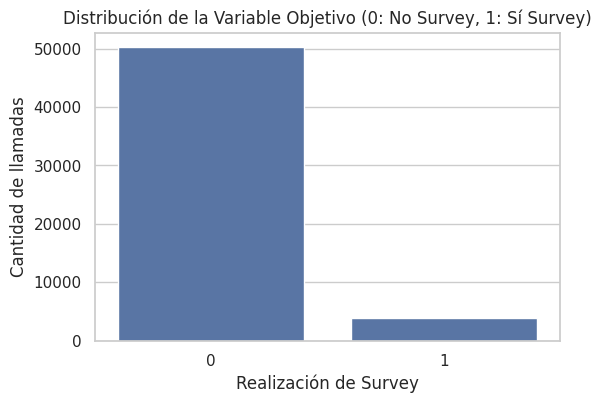

In [86]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Survey', data=df_model)
plt.title('Distribución de la Variable Objetivo (0: No Survey, 1: Sí Survey)')
plt.xlabel('Realización de Survey')
plt.ylabel('Cantidad de llamadas')
target_dist = df['Survey'].value_counts(normalize=True) * 100

plt.show()

Conclusión de la grafica: En la grafica podemos observar como tenemos un data set desbalanceado por la misma naturaleza de los surveys en los que es un bajo porcentaje el numeor de personas que realmente llena la encuesta de satisfacción al final de la llamada.

##Analisis de las variables numericas

In [87]:
numerical_features = df_model.select_dtypes(include=np.number).columns.tolist()
numerical_features

['Wait Time', 'Call Duration in Minutes', 'Survey']

En este caso, Survey es una variable categorica ya que esta expresa si se recibió el survey o no

In [88]:
categorical_coded_num = ['Survey']

In [89]:
numerical_continuous = [col for col in numerical_features if col not in categorical_coded_num]

In [90]:
#Ahora viendo las variables que son realmente numericas
numerical_continuous

['Wait Time', 'Call Duration in Minutes']

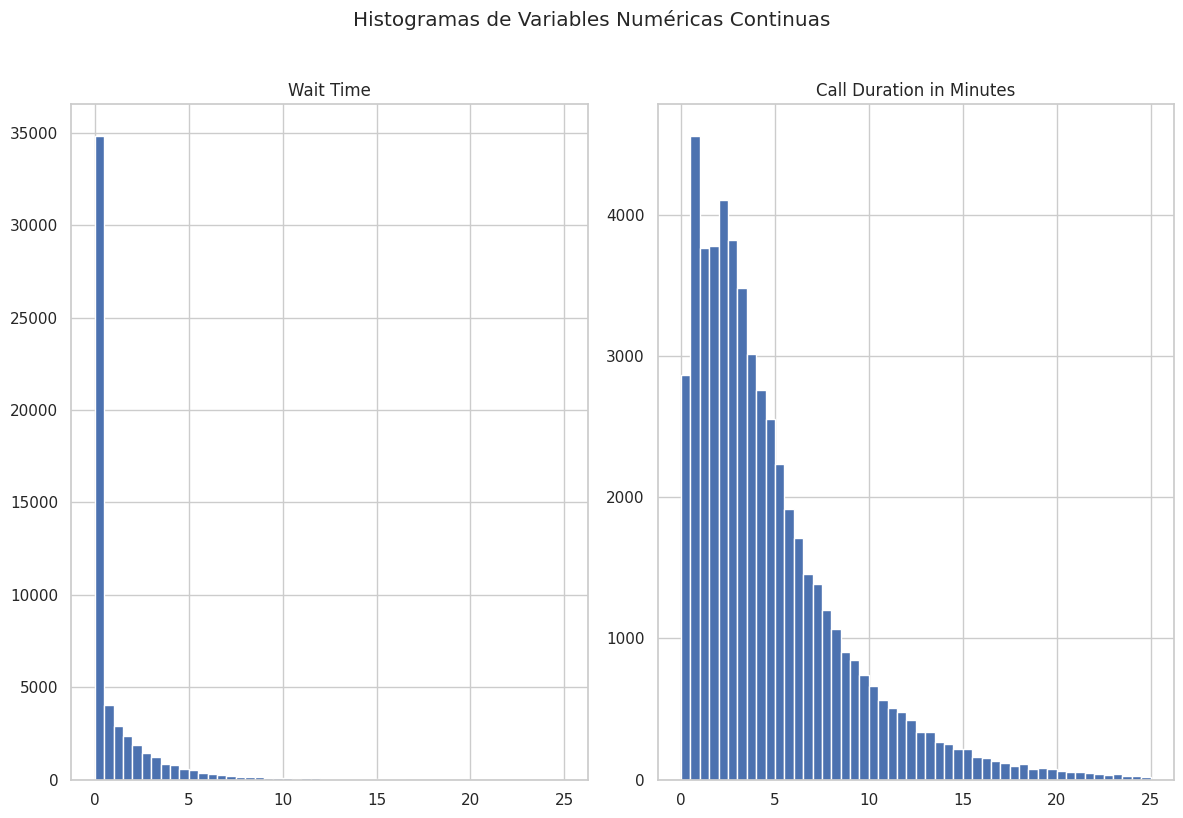

In [91]:
# Histogramas para variables continuas
df_model[numerical_continuous].hist(figsize=(12, 8), bins=50, range=(0, 25))
plt.suptitle('Histogramas de Variables Numéricas Continuas', y=1.02)
plt.tight_layout()
plt.show()

Vemos que en la mayoria de las llamadas, los tiempos de espera son bajos y vemos que la duración de las llamadas se suele encontrar debajo de 5 minutos lo cual está dentro de los tiempos aceptados


Boxplots de Variables Numéricas Continuas vs Survey:


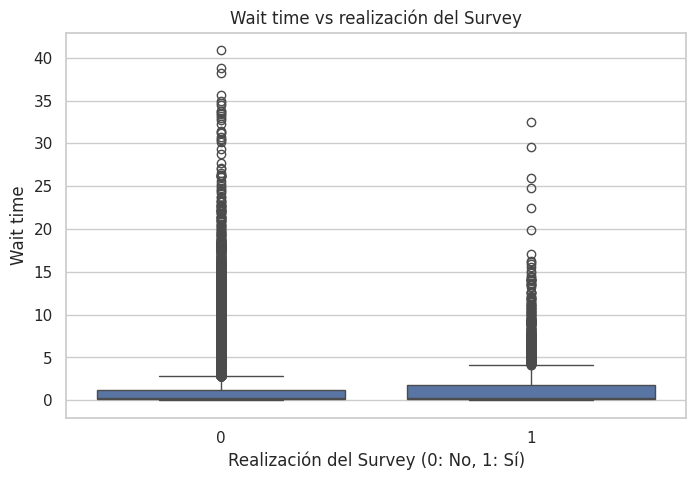

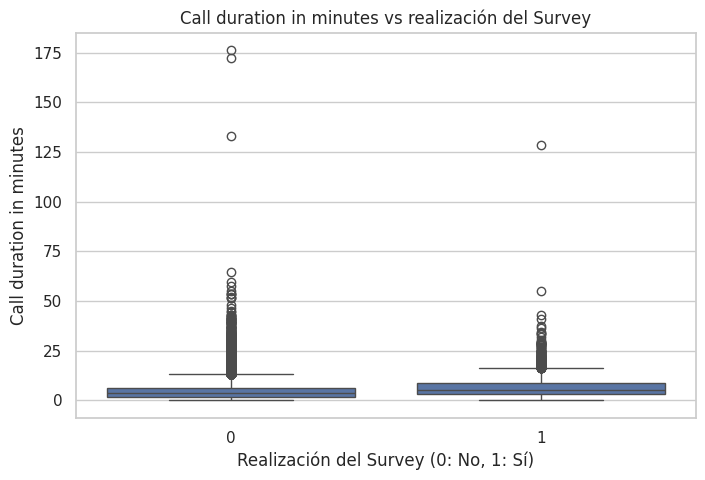

In [92]:
# Boxplots para variables continuas vs Survey
print("\nBoxplots de Variables Numéricas Continuas vs Survey:")
for col in numerical_continuous:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='Survey', y=col, data=df_model)
    plt.title(f'{col.capitalize()} vs realización del Survey')
    plt.xlabel('Realización del Survey (0: No, 1: Sí)')
    plt.ylabel(col.capitalize())
    plt.show()

Vemos en las graficas que hay muchos valores considerados atipicos debido al volumen de llamadas que se encuentran dentro de los rangos

##Análisis de variables categóricas (incluyendo las codificadas numéricamente)

In [93]:
categorical_features = ['Client','Queue Name', 'Owner Name']

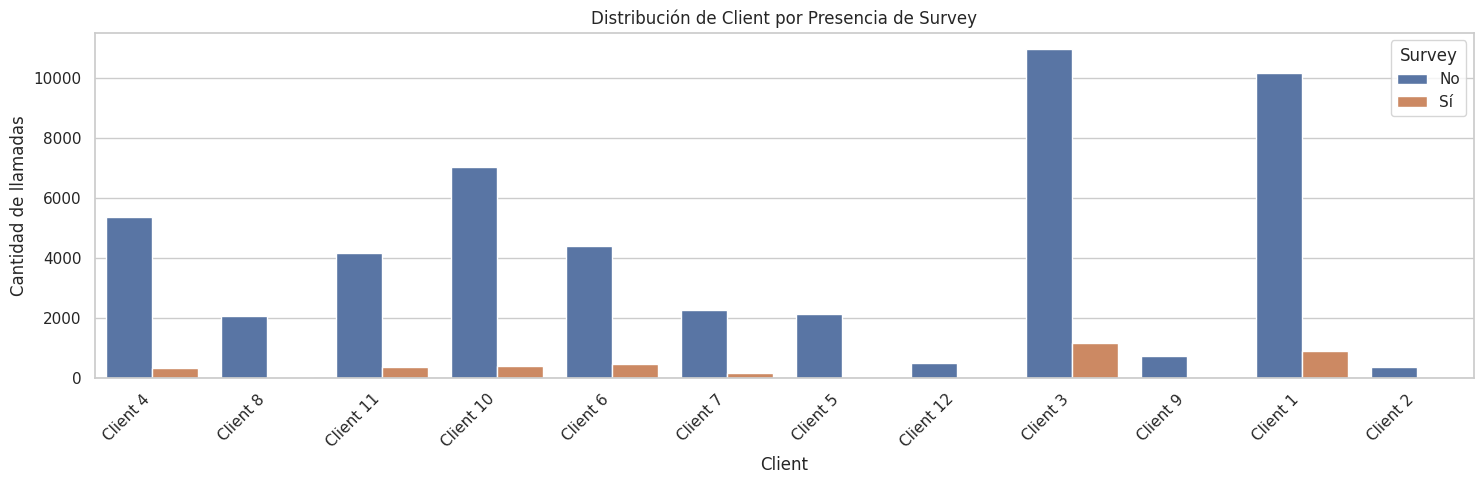

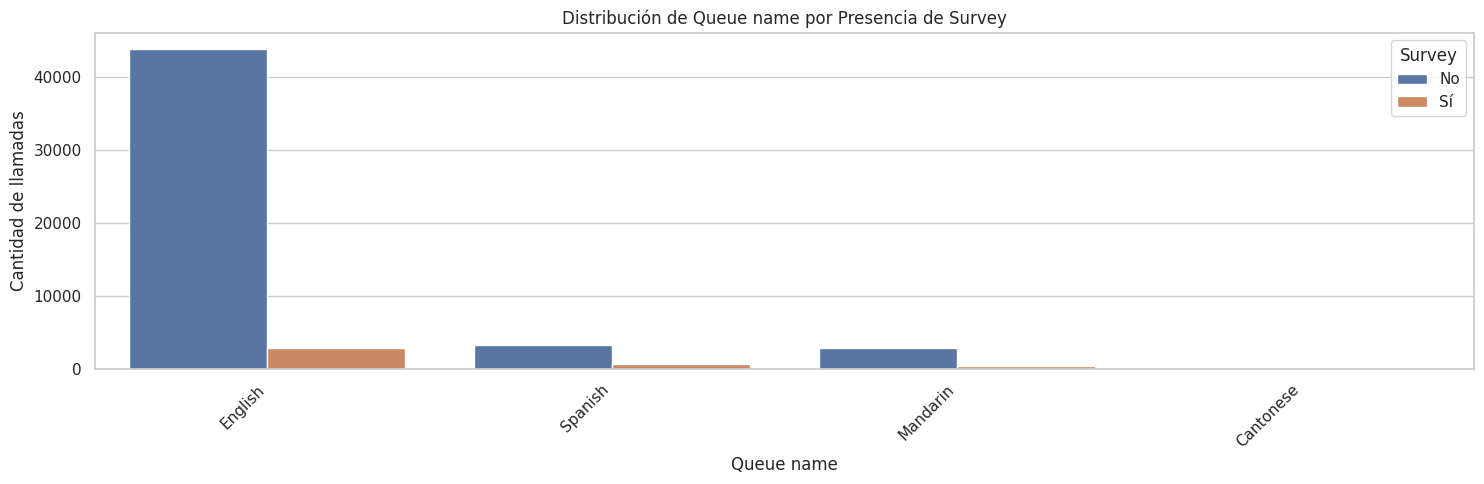

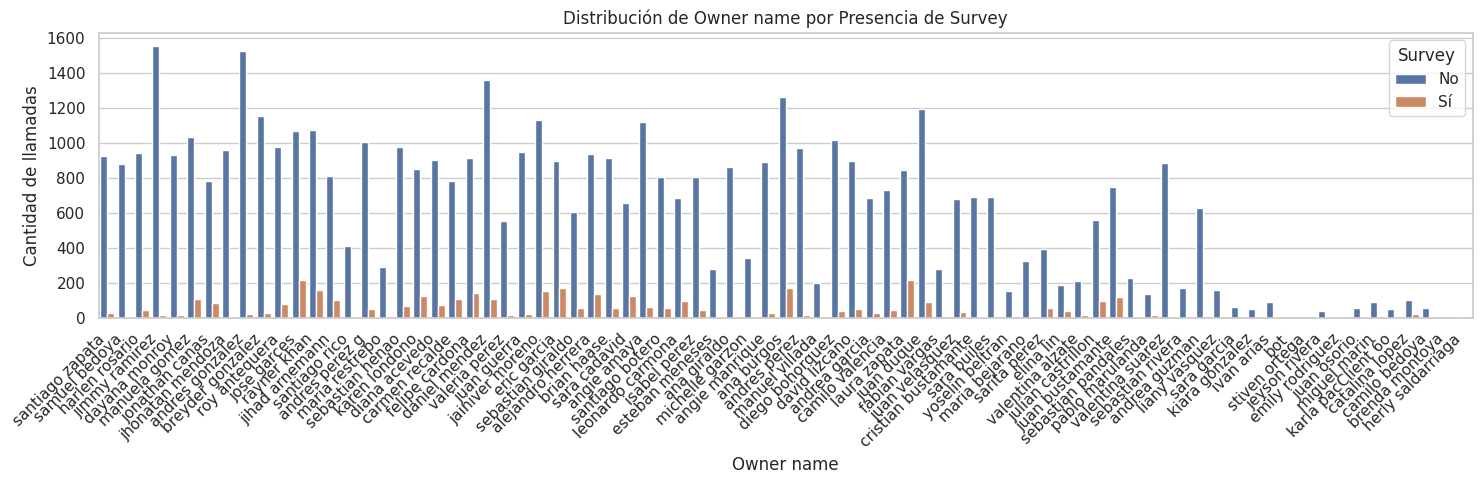

In [103]:
# Countplots para variables categóricas
for col in categorical_features:
    plt.figure(figsize=(15, 5))
    sns.countplot(x=col, data=df_model, hue='Survey')
    plt.title(f'Distribución de {col.capitalize()} por Presencia de Survey')
    plt.xlabel(col.capitalize())
    plt.ylabel('Cantidad de llamadas')
    plt.legend(title='Survey', labels=['No', 'Sí'])
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

Vemos el resultado de las variables categoricas en las que podemos ver que el mayor volumen de llamadas son en English y podemos ver como existen distintas distribuciones por clientes.

## Matriz de Correlación (solo para numéricas continuas y Survey)

In [102]:
# Incluimos 'Survey' para ver correlaciones con la variable objetivo
corr_features = numerical_continuous + ['Survey']
correlation_matrix = df_model[corr_features].corr()

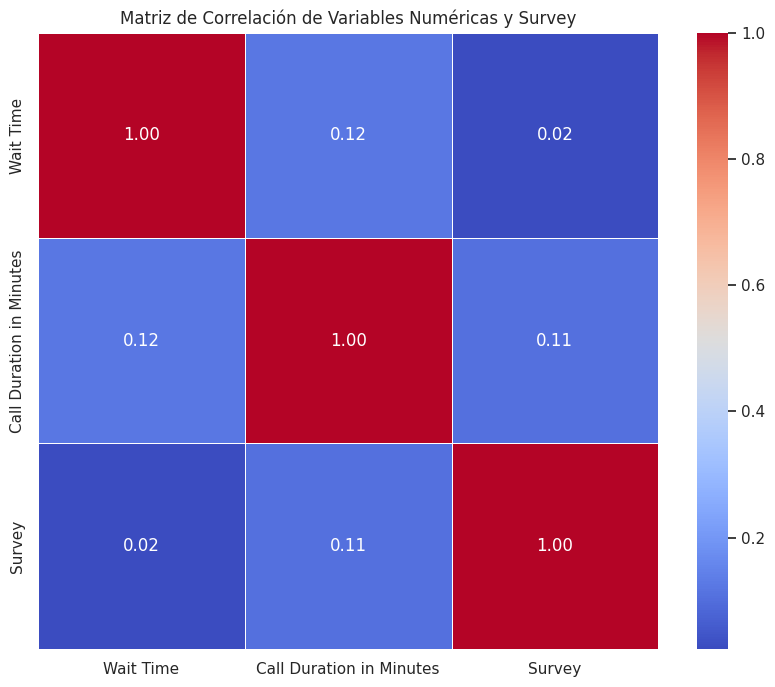

In [104]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlación de Variables Numéricas y Survey')
plt.show()

Vemos que existe una relación muy baja entre Survey y Call Duration y Wait time.

In [105]:
#Organizando descendentes para facilidad de visualizar los resultados:
print("Correlaciones con la variable 'Survey':")
correlation_matrix['Survey'].sort_values(ascending=False)

,Survey
Survey,1.000000
Call Duration in Minutes,0.106834
Wait Time,0.023803


In [109]:
#Actualizamos las listas de caracteristicas categoricas y numericas a codificar
categorical_features_for_encoding = categorical_features

numerical_features_for_scaling = numerical_continuous


In [110]:
# Lista completa de características a usar (excluyendo 'target')
features = numerical_features_for_scaling + categorical_features_for_encoding
survey = 'Survey'

print(f"\nCaracterísticas numéricas a escalar: {numerical_features_for_scaling}")
print(f"Características categóricas a codificar (OneHot): {categorical_features_for_encoding}")
print(f"Variable objetivo: {Survey}")
print("\n")


Características numéricas a escalar: ['Wait Time', 'Call Duration in Minutes']
Características categóricas a codificar (OneHot): ['Client', 'Queue Name', 'Owner Name']
Variable objetivo: Survey




##Procesamiento de Datos

In [112]:
# Definir las características (X) y la variable objetivo (y)
X = df_model[features]
Y = df_model[survey]

In [116]:
# Crear el preprocesador usando ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features_for_scaling),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_for_encoding)
    ],
    remainder='passthrough'
)

In [117]:
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num', StandardScaler(),
                                 ['Wait Time', 'Call Duration in Minutes']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['Client', 'Queue Name', 'Owner Name'])])

##División de Datos (Train/Test Split)

In [119]:
#Dividimos lso datos antes del procesamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [121]:
print(f"Tamaño del conjunto de entrenamiento (X_train): {X_train.shape}")
print(f"Tamaño del conjunto de prueba (X_test): {X_test.shape}")
print(f"Tamaño del conjunto de entrenamiento (y_train): {y_train.shape}")
print(f"Tamaño del conjunto de prueba (y_test): {y_test.shape}")

Tamaño del conjunto de entrenamiento (X_train): (40594, 5)
Tamaño del conjunto de prueba (X_test): (13532, 5)
Tamaño del conjunto de entrenamiento (y_train): (40594,)
Tamaño del conjunto de prueba (y_test): (13532,)


In [122]:
print("\nDistribución de la variable objetivo en Train vs Test:")
print(f"Train: \n{y_train.value_counts(normalize=True)}")
print(f"Test: \n{y_test.value_counts(normalize=True)}")


Distribución de la variable objetivo en Train vs Test:
Train: 
Survey
0    0.927477
1    0.072523
Name: proportion, dtype: float64
Test: 
Survey
0    0.927431
1    0.072569
Name: proportion, dtype: float64


##Construcción y Entrenamiento del Modelo (Random Forest)

In [123]:
#Creamos el pipleine incluyendo el preprocesador y el clasificador
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])

In [124]:
# Entrenando el pipeline completo (preprocesamiento + modelo)
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Wait Time',
                                                   'Call Duration in Minutes']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Client', 'Queue Name',
                                                   'Owner Name'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

##Evaluación del modelo

In [125]:
# Realizamos predicciones en el conjunto de prueba
y_pred = model_pipeline.predict(X_test)
y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1]

In [127]:
#Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"--- Accuracy Score ---")
print(f"Accuracy en el conjunto de prueba: {accuracy:.4f}")

--- Accuracy Score ---
Accuracy en el conjunto de prueba: 0.9112



--- Matriz de Confusión ---


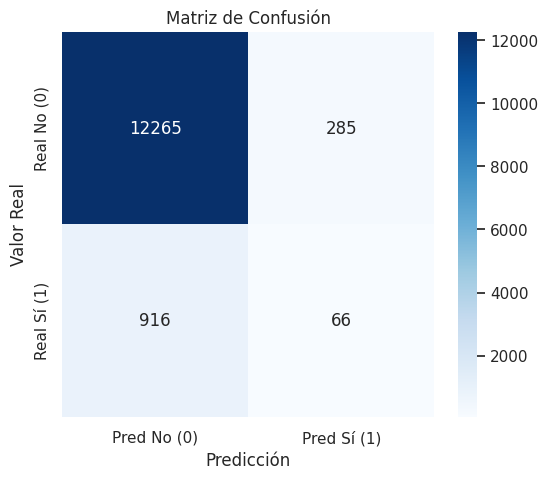

Verdaderos Negativos (TN): 12265
Falsos Positivos (FP): 285
Falsos Negativos (FN): 916
Verdaderos Positivos (TP): 66


In [128]:
#Confusion Matriz
print("\n--- Matriz de Confusión ---")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred No (0)', 'Pred Sí (1)'], yticklabels=['Real No (0)', 'Real Sí (1)'])
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')
plt.show()
print(f"Verdaderos Negativos (TN): {cm[0,0]}")
print(f"Falsos Positivos (FP): {cm[0,1]}")
print(f"Falsos Negativos (FN): {cm[1,0]}")
print(f"Verdaderos Positivos (TP): {cm[1,1]}")

Vemos que en el modelo, el principal soporte lo tenemos al momento de tener en cuenta los Verdaderos negativos. Esto nos ayuda a entender y predecir los verdaderos negativos

In [129]:
#Reporte de Clasificación (Precisión, Recall, F1-Score)
target_names = ['No Survey (0)', 'Sí Survey (1)']
print(classification_report(y_test, y_pred, target_names=target_names))

               precision    recall  f1-score   support

No Survey (0)       0.93      0.98      0.95     12550
Sí Survey (1)       0.19      0.07      0.10       982

     accuracy                           0.91     13532
    macro avg       0.56      0.52      0.53     13532
 weighted avg       0.88      0.91      0.89     13532



In [131]:
#Curva ROC y AUC

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

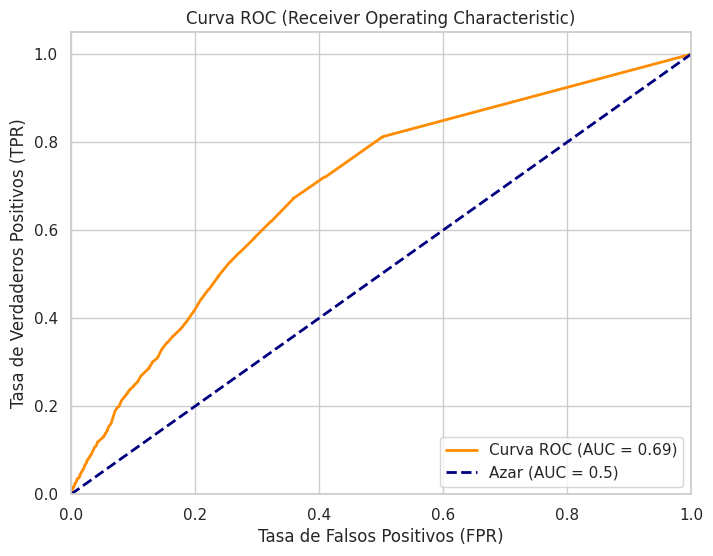

In [132]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Azar (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC (Receiver Operating Characteristic)')
plt.legend(loc="lower right")
plt.show()

Vemos que el area sobre la curva sigue siendo sobre el 50% correspondiente al Azar. El modelo obtiene un AUC medianamente aceptable al estar sobre el 50%

In [133]:
print(f"Área Bajo la Curva ROC (AUC): {roc_auc:.4f}")

Área Bajo la Curva ROC (AUC): 0.6920


##Análisis de Importancia de Características

In [135]:
# Para obtener la importancia, necesitamos acceder al clasificador DENTRO del pipeline
rf_classifier = model_pipeline.named_steps['classifier']
importances = rf_classifier.feature_importances_

In [137]:
# Obtener el transformador OneHotEncoder del preprocesador
ohe_transformer = model_pipeline.named_steps['preprocessor'].transformers_[1][1]
# Obtener las categorías de las características codificadas
ohe_categories = ohe_transformer.categories_

In [139]:
ohe_categories

[array(['Client 1', 'Client 10', 'Client 11', 'Client 12', 'Client 2',
        'Client 3', 'Client 4', 'Client 5', 'Client 6', 'Client 7',
        'Client 8', 'Client 9'], dtype=object),
 array(['Cantonese', 'English', 'Mandarin', 'Spanish'], dtype=object),
 array(['alejandro herrera', 'ana burgos', 'ana giraldo', 'andrea garcia',
        'andrea guzman', 'andres gonzalez', 'andres perez',
        'andres perez g', 'angie amaya', 'angie manrique', 'bot',
        'brenda montoya', 'breyder gonzalez', 'brian haase',
        'camilo bedoya', 'camilo valencia', 'carmen recalde',
        'catalina lopez', 'cristian bustamante', 'daniel mendez',
        'david lizcano', 'dayana monroy', 'diana acevedo',
        'diego bohorquez', 'elina lin', 'emily rodriguez', 'eric garcia',
        'esteban meneses', 'fabian vargas', 'felipe cardona',
        'harlen rosario', 'herly saldarriaga', 'isabel perez',
        'ivan arias', 'jainiver moreno', 'jeyson rivera',
        'jhonatan mendoza', 'jihad a

In [141]:
#Creando los nombres de las caracteristicas codificadas
ohe_feature_names = []
for i, col in enumerate(categorical_features_for_encoding):
    for category in ohe_categories[i]:
        ohe_feature_names.append(f"{col}_{category}")

In [142]:
ohe_feature_names

['Client_Client 1',
 'Client_Client 10',
 'Client_Client 11',
 'Client_Client 12',
 'Client_Client 2',
 'Client_Client 3',
 'Client_Client 4',
 'Client_Client 5',
 'Client_Client 6',
 'Client_Client 7',
 'Client_Client 8',
 'Client_Client 9',
 'Queue Name_Cantonese',
 'Queue Name_English',
 'Queue Name_Mandarin',
 'Queue Name_Spanish',
 'Owner Name_alejandro herrera',
 'Owner Name_ana burgos',
 'Owner Name_ana giraldo',
 'Owner Name_andrea garcia',
 'Owner Name_andrea guzman',
 'Owner Name_andres gonzalez',
 'Owner Name_andres perez',
 'Owner Name_andres perez g',
 'Owner Name_angie amaya',
 'Owner Name_angie manrique',
 'Owner Name_bot',
 'Owner Name_brenda montoya',
 'Owner Name_breyder gonzalez',
 'Owner Name_brian haase',
 'Owner Name_camilo bedoya',
 'Owner Name_camilo valencia',
 'Owner Name_carmen recalde',
 'Owner Name_catalina lopez',
 'Owner Name_cristian bustamante',
 'Owner Name_daniel mendez',
 'Owner Name_david lizcano',
 'Owner Name_dayana monroy',
 'Owner Name_diana ace

In [144]:
#Ahora combinamos los nombres de caracteristicas numericas y codificadas
final_feature_names = numerical_features_for_scaling + ohe_feature_names

Importancia de las características según Random Forest:
                       Feature  Importance
1     Call Duration in Minutes    0.486632
0                    Wait Time    0.295665
15          Queue Name_English    0.016856
17          Queue Name_Spanish    0.011547
9              Client_Client 5    0.011421
12             Client_Client 8    0.006451
23  Owner Name_andres gonzalez    0.006187
56    Owner Name_jimmy ramirez    0.006078
58      Owner Name_jose garces    0.005864
68     Owner Name_laura zapata    0.005732
24     Owner Name_andres perez    0.005043
84      Owner Name_sara builes    0.004748
47   Owner Name_felipe cardona    0.004448
20      Owner Name_ana giraldo    0.004083
85     Owner Name_sara cadavid    0.003994


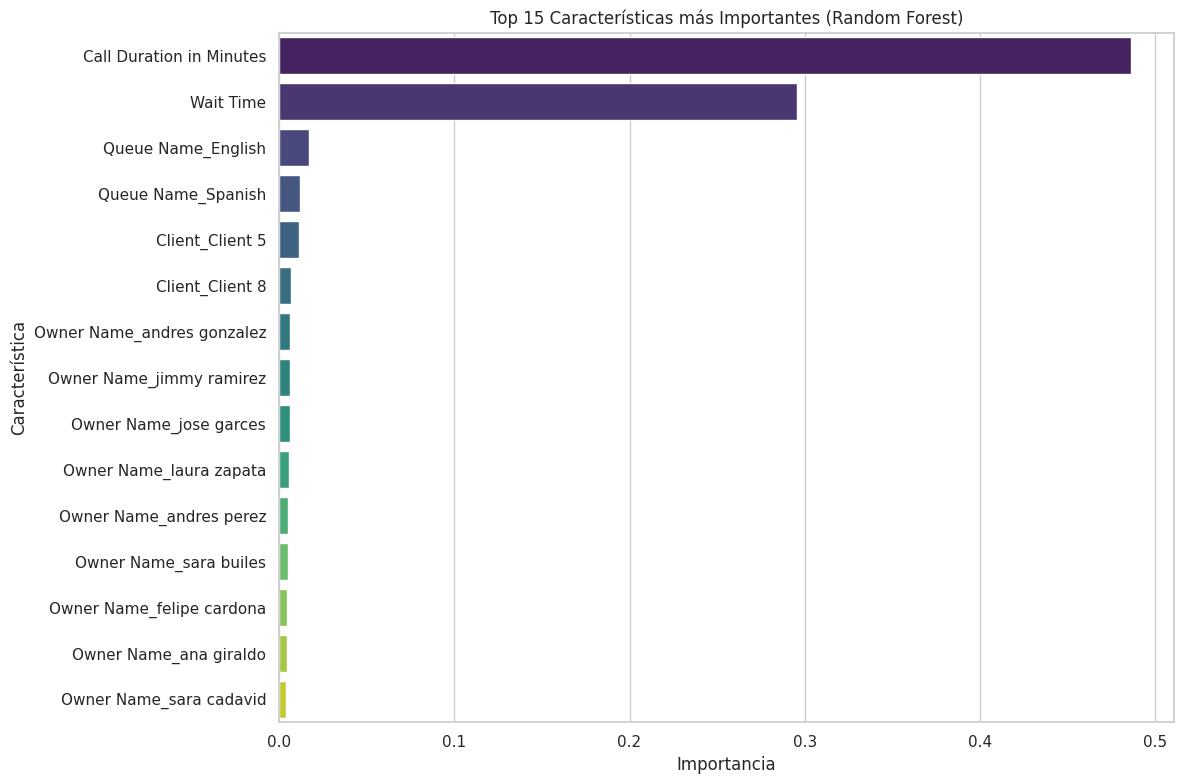

In [145]:
#Creamos un Data Frame para visualizar la importancia
if len(importances) == len(final_feature_names):
    feature_importance_df = pd.DataFrame({'Feature': final_feature_names, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    print("Importancia de las características según Random Forest:")
    print(feature_importance_df.head(15)) # Mostrar las 15 más importantes

    # Graficar la importancia de las características
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15), palette='viridis', hue='Feature')
    plt.title('Top 15 Características más Importantes (Random Forest)')
    plt.xlabel('Importancia')
    plt.ylabel('Característica')
    plt.tight_layout()
    plt.show()

##Conclusiones

In [146]:
print("Resumen de Resultados:")
print(f"- Accuracy del modelo en el conjunto de prueba: {accuracy:.4f}")
print(f"- AUC del modelo en el conjunto de prueba: {roc_auc:.4f}")
print("- El reporte de clasificación muestra buena Precisión, Recall y F1-Score para ambas clases (0 y 1).")

Resumen de Resultados:
- Accuracy del modelo en el conjunto de prueba: 0.9112
- AUC del modelo en el conjunto de prueba: 0.6920
- El reporte de clasificación muestra buena Precisión, Recall y F1-Score para ambas clases (0 y 1).


###Validación de la Hipotesis
LA hipotesis alternativa (H1) planteaba que era posible predecir el llenado de la encuesta de Satisfacción (Survey) con una presición del >70% y un AUC>0.5 usando las caracteristicas dadas y un Random Forest

In [147]:
print(f"Obtuvimos una Accuracy de {accuracy:.2f} y un AUC de {roc_auc:.2f}.")

if accuracy > 0.75 and roc_auc > 0.5:
    print("RESULTADO: La hipótesis alternativa (H1) es soportada por los resultados. El modelo supera el umbral de precisión y es significativamente mejor que el azar.")
    print("Rechazamos la hipótesis nula (H0).")
else:
    print("RESULTADO: La hipótesis alternativa (H1) no es completamente soportada. Aunque el AUC indica un rendimiento mejor que el azar, la precisión podría no haber alcanzado el umbral deseado del 70%.")
    print("Se necesita revisar el modelo o los datos.")

Obtuvimos una Accuracy de 0.91 y un AUC de 0.69.
RESULTADO: La hipótesis alternativa (H1) es soportada por los resultados. El modelo supera el umbral de precisión y es significativamente mejor que el azar.
Rechazamos la hipótesis nula (H0).


###Analisis Adicional

*   La matriz de confusión muestra que quien soporta pricipalmente al modelo son los Verdaderos negativos debido a la distribución inicial que se tienen de los datos
*   El analisis de importancia sugiere que la duración de las llamadas y el tiempo de espera de la llamada son muy influyentes en la predicción
*   El modelo se adapta relativamente bien para lo que se desea.
*   LA caracteristica de 'Owner' vemos que no es tan relevante al momento de hacer el estudio ya que existen muchos owners y se dispersan en la data. Restandole importancia







###Next Steps

*   Obtener una base de datos más equilibrada de forma de poder obtener un analisis mejor distribuido
*   Realizar el modelo teniendo en cuenta la diferencia entre los clientes

